# Downloading the pip package

In [1]:
from deeplense_domain_adaptation.data import augmentations

train_transform, test_transform = augmentations.supervised_augmentations()!pip install --upgrade deeplense_domain_adaptation

     |████████████████████████████████| 40 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 4.4 kB/s  eta 0:00:01   |▊                               | 17.4 MB 890 kB/s eta 0:15:15     |█▌                              | 39.9 MB 24.1 MB/s eta 0:00:33     |██▊                             | 70.6 MB 18.2 MB/s eta 0:00:42     |███                             | 75.4 MB 18.2 MB/s eta 0:00:42     |███                             | 78.5 MB 18.2 MB/s eta 0:00:42     |████████████▋                   | 326.7 MB 26.2 MB/s eta 0:00:20     |████████████████▍               | 425.3 MB 47.1 MB/s eta 0:00:09     |████████████████▍               | 426.8 MB 47.1 MB/s eta 0:00:09     |████████████████▌               | 429.9 MB 13.9 MB/s eta 0:00:29     |█████████████████▍              | 450.7 MB 13.9 MB/s eta 0:00:28     |█████████████████▌              | 453.5 MB 13.9 MB/s eta 0:00:28     |█████████████████▋              | 458.4 MB 35.9 MB/s eta 0:00:11     |██████████████████       

# Preparations

In [2]:
import deeplense_domain_adaptation
import torch
import matplotlib.pyplot as plt

plt.style.use('seaborn')

Define path to source and target domain data:

In [3]:
# source domain: model_f
model_f_train_data_path = "../input/deeplense3classes-source/Data/f/f_train_data_zoom-rotation.npy"
model_f_train_labels_path = "../input/deeplense3classes-source/Data/f/f_train_labels_zoom-rotation.npy"

model_f_test_data_path = "../input/deeplense3classes-rest/Data/f/f_test_data.npy"
model_f_test_labels_path = "../input/deeplense3classes-rest/Data/f/f_test_labels.npy"

# target domain: model_j
model_j_train_data_path = "../input/deeplense3classes-rest/Data/j/j_train_data.npy"
model_j_train_labels_path = "../input/deeplense3classes-rest/Data/j/j_train_labels.npy"

model_j_test_data_path = "../input/deeplense3classes-rest/Data/j/j_test_data.npy"
model_j_test_labels_path = "../input/deeplense3classes-rest/Data/j/j_test_labels.npy"

# Supervised learning

## Loading data

We can load data using the `get_dataloader` function in `data.dataset`. There's also a `NumpyDataset` class which enables the creation of a more customized way of loading the data.

We can use the transforms available at `data.augmentations` or create custom ones. Note that if you plan on creating custom transforms, be careful that different algorithms require different kinds of augmentations. You can refer to the functions at `data.augmentations` for reference.

In [4]:
from deeplense_domain_adaptation.data import augmentations

train_transform, test_transform = augmentations.supervised_augmentations()

We then create dataloaders from our data:

In [5]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

## Setting up model

In order to set up our model we need to get network that we'll be using (from `networks.*`), the hyperparameters for our algorithms (from `data.hyperparams`) and then call the algorithm class (from `algorithms.*`).

First we'll call the encoder and classifier. In this example we'll be using the ResNet architecture, but it's the same process for the Equivariant Neural Network architecture.

In [12]:
from deeplense_domain_adaptation.networks import resnet

encoder = resnet.Encoder('18')
classifier = resnet.Classifier()

Then we get the hyperparameters for the algorithm we're using:

In [13]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.supervised_hyperparams(wd=5e-5)

And finally we'll call the algorithm class and set it up:

In [14]:
from deeplense_domain_adaptation.algorithms import supervised

supervised = supervised.Supervised(encoder, classifier)

## Train and evaluate the model

Now we have everything we need to train and evaluate our model.

When training the model, you can set the epochs to be a pretty large number since there's an early stopping implementation. If the accuracy of the model on the validation set (`dataloader_test`) doesn't improve in more than 15 epochs, training will stop.

`save_path` is where the encoder and classifier weights will be saved, so that they can be loaded afterwards. To prevent saving an overfitted model, the algorithm will save only the model that had the best accuracy on the validation set.

In [15]:
epochs = 50
save_path = "./supervised.pt"

encoder, classifier = supervised.train(source_dataloader, source_dataloader_test, epochs, hparams, save_path)

[Epoch 1/50] loss: 1.103201; accuracy: 0.340467; val accuracy: 0.336667;
[Epoch 2/50] loss: 1.100665; accuracy: 0.350033; val accuracy: 0.360133;
[Epoch 3/50] loss: 1.098798; accuracy: 0.333667; val accuracy: 0.342400;
[Epoch 4/50] loss: 1.089423; accuracy: 0.343000; val accuracy: 0.333467;
[Epoch 5/50] loss: 1.076755; accuracy: 0.399867; val accuracy: 0.333333;
[Epoch 6/50] loss: 1.052418; accuracy: 0.451200; val accuracy: 0.333333;
[Epoch 7/50] loss: 1.014371; accuracy: 0.333467; val accuracy: 0.333333;
[Epoch 8/50] loss: 0.978136; accuracy: 0.368333; val accuracy: 0.333333;
[Epoch 9/50] loss: 0.945173; accuracy: 0.428767; val accuracy: 0.368667;
[Epoch 10/50] loss: 0.918566; accuracy: 0.550833; val accuracy: 0.340533;
[Epoch 11/50] loss: 0.874607; accuracy: 0.396867; val accuracy: 0.333333;
[Epoch 12/50] loss: 0.817832; accuracy: 0.335900; val accuracy: 0.333333;
[Epoch 13/50] loss: 0.684477; accuracy: 0.420700; val accuracy: 0.552933;
[Epoch 14/50] loss: 0.519377; accuracy: 0.60196

We can then print the model's training metrics:

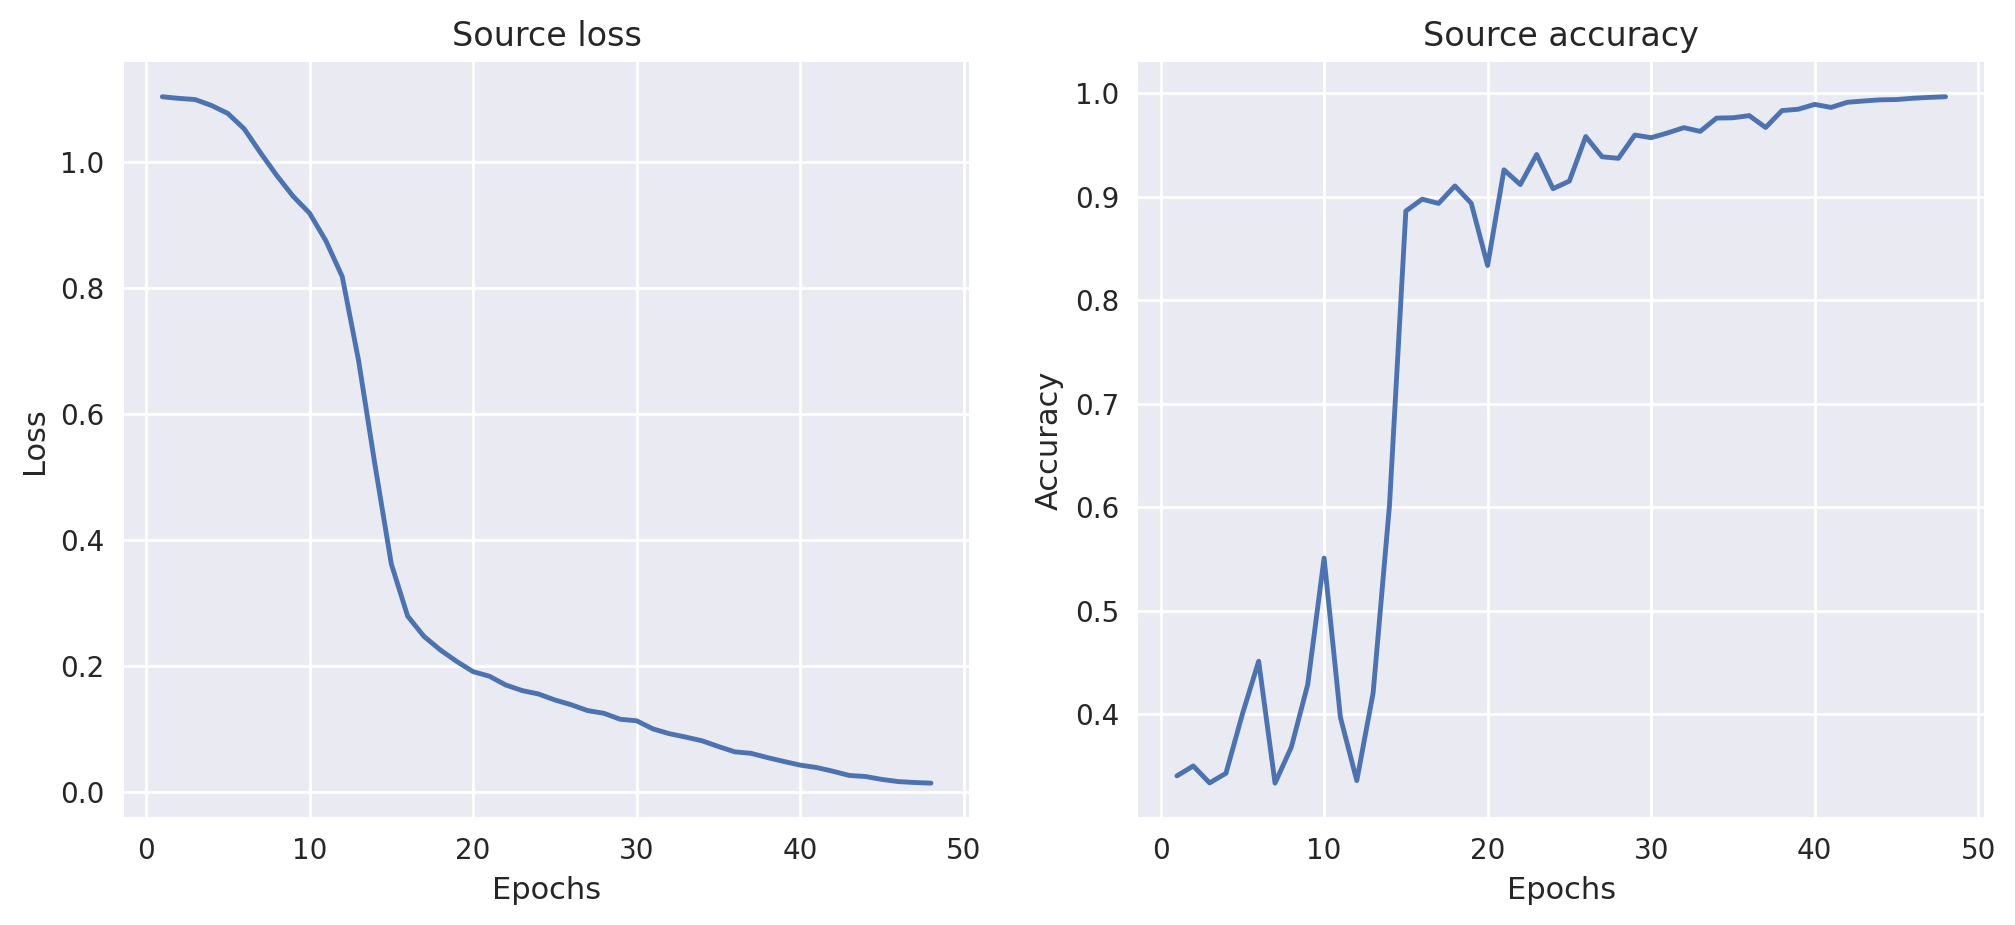

In [16]:
supervised.plot_metrics()

And evaluate it on the test set:

accuracy on test set = 0.9482666666666667


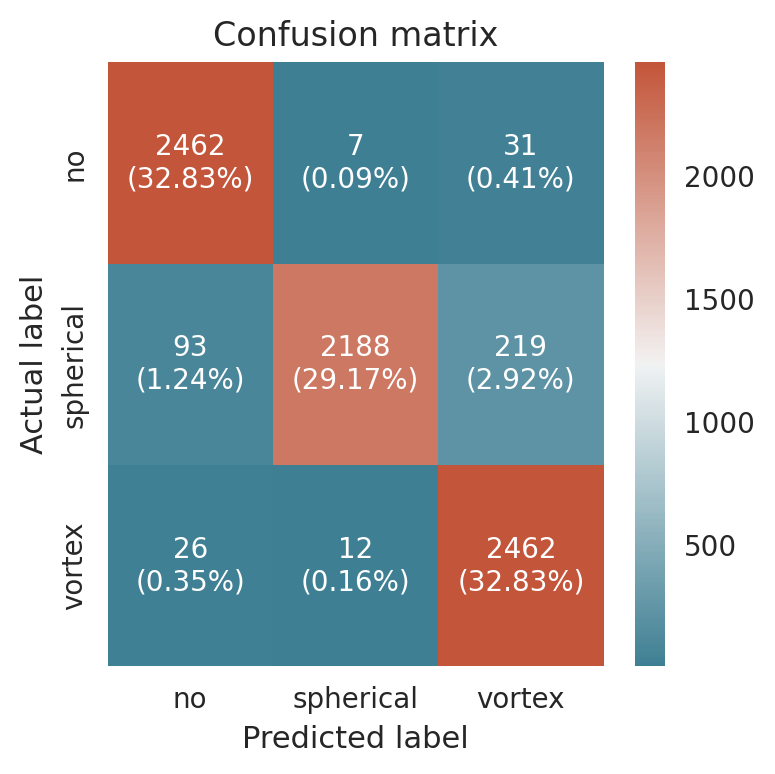

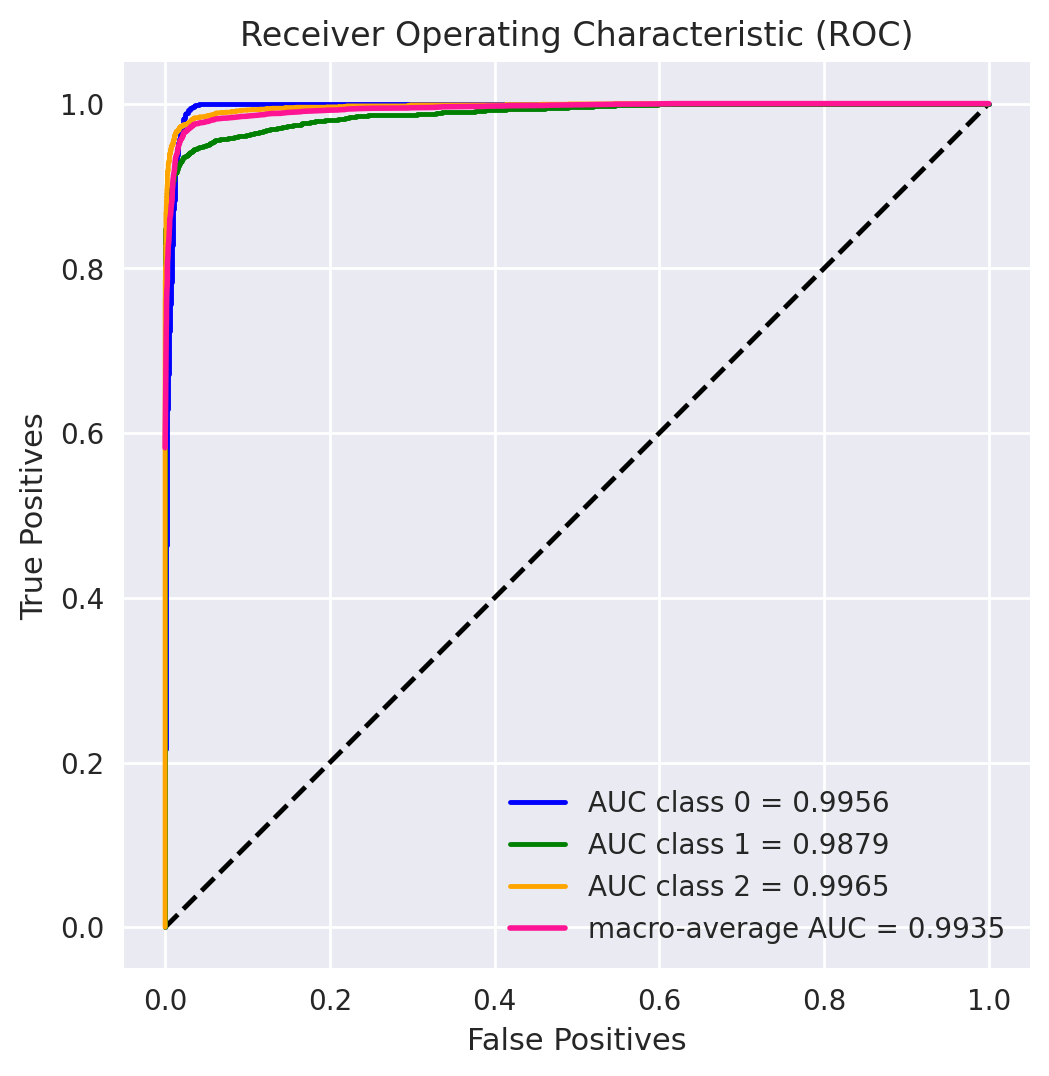

In [17]:
# returns accuracy on the test set
print(f"accuracy on test set = {supervised.evaluate(source_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
supervised.plot_cm_roc(source_dataloader_test)

# Domain Adaptation (with ADDA)

ADDA (from **Adversarial Discriminative Domain Adaptation** by _Eric Tzeng, Judy Hoffman, Kate Saenko, Trevor Darrell_) is an adversarial domain adaptation method, where the goal is to minimize the domain discrepancy distance through an adversarial objective with respect to a discriminator. 

We want the discriminator to be unable to distinguish between the source and the target distributions!

ADDA learns a discriminative representations using the labels in the source domain and then a separate encoding that maps the target data to the same space. Our goal is to fool the domain discriminator so that it is unable to distinguish the source from the target.

In order to train ADDA, we must use the encoder and classifier trained on the source as initial inputs. In more practical terms: we must use the encoder and classifier that were trained with `Supervised`. While this is the only algorithm that **needs** this kind of transfer learning, this technique is beneficial to the other algorithms, which is the reason we use it.

## Loading data

Since we'll apply a UDA algorithm, we'll need to load both the source and the target domain data. We found that, on our data, it's beneficial to apply different transforms to the source and the target data. Applying random zoom transforms to the source data, for example, helps improve the performance on the target dataset. In this example we're not going to use this since the source dataset has been already modified to have random zoom and rotation augmentations.

In [18]:
from deeplense_domain_adaptation.data import augmentations

train_transform_source, train_transform_target, test_transform = augmentations.adda_augmentations()

In [19]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform_source, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

target_dataloader = get_dataloader(model_j_train_data_path, model_j_train_labels_path, train_transform_target, bs)
target_dataloader_test = get_dataloader(model_j_test_data_path, model_j_test_labels_path, test_transform, bs)

## Setting up model

For ADDA we need to use a discriminator network.

We'll load the encoder and classifier weights from our model trained on a supervised manner on the source dataset:

In [20]:
from deeplense_domain_adaptation.networks import resnet
from deeplense_domain_adaptation.networks import discriminator

source_encoder = resnet.Encoder('18')
target_encoder = resnet.Encoder('18')
classifier = resnet.Classifier()
discriminator = discriminator.Discriminator()

supervised_path = "./supervised.pt"
supervised_weights = torch.load(supervised_path)

source_encoder.load_state_dict(supervised_weights['encoder_weights'])
classifier.load_state_dict(supervised_weights['classifier_weights'])

<All keys matched successfully>

Get the hyperparameters for ADDA:

In [21]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.adda_hyperparams(wd=5e-5)

Instantiate ADDA:

In [22]:
from deeplense_domain_adaptation.algorithms import adda

adda = adda.Adda(source_encoder, target_encoder, classifier, discriminator)

### Train and evaluate the model
Now we have everything we need to train and evaluate our model.

Just like `Supervised`, the UDA algorithms also have early stopping. The difference is that we measure the accuracy of the model on the target dataset validation set (`target_dataloader_test`).

In [23]:
epochs = 50
save_path = "./adda.pt"

encoder, classifier = adda.train(source_dataloader, target_dataloader, target_dataloader_test, epochs, hparams, save_path)

[Epoch 1/50] discriminator loss: 0.678454; target loss: 0.701474; accuracy target: 0.789200; val accuracy: 0.782400;
[Epoch 2/50] discriminator loss: 0.665523; target loss: 0.751944; accuracy target: 0.812167; val accuracy: 0.807333;
[Epoch 3/50] discriminator loss: 0.595245; target loss: 0.849651; accuracy target: 0.816267; val accuracy: 0.808133;
[Epoch 4/50] discriminator loss: 0.656968; target loss: 0.802904; accuracy target: 0.814400; val accuracy: 0.808533;
[Epoch 5/50] discriminator loss: 0.587723; target loss: 0.880494; accuracy target: 0.799333; val accuracy: 0.793333;
[Epoch 6/50] discriminator loss: 0.665744; target loss: 0.769739; accuracy target: 0.822367; val accuracy: 0.816533;
[Epoch 7/50] discriminator loss: 0.639197; target loss: 0.834734; accuracy target: 0.829467; val accuracy: 0.825467;
[Epoch 8/50] discriminator loss: 0.521470; target loss: 1.006484; accuracy target: 0.828600; val accuracy: 0.823067;
[Epoch 9/50] discriminator loss: 0.608485; target loss: 0.868884

We can then print the training metrics:

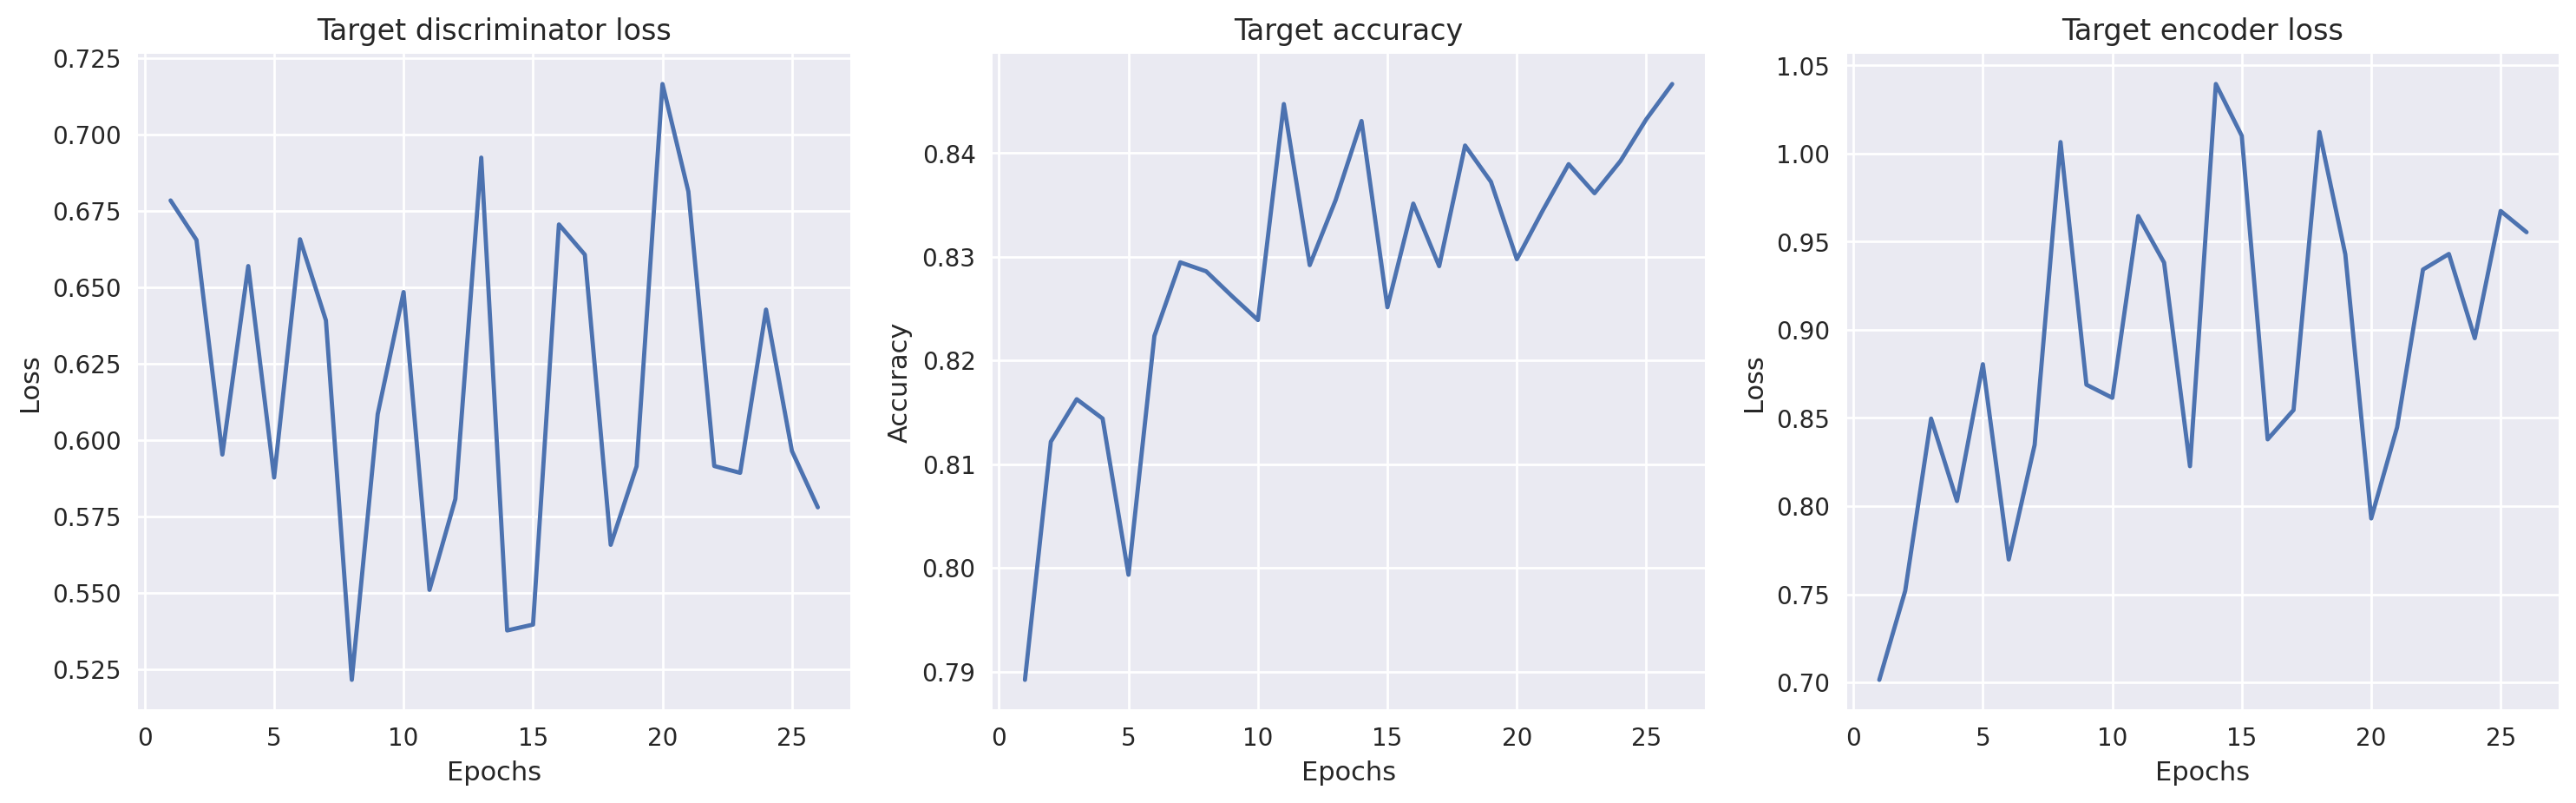

In [24]:
adda.plot_metrics()

And evaluate it on the test set:

accuracy on test set = 0.8437333333333333


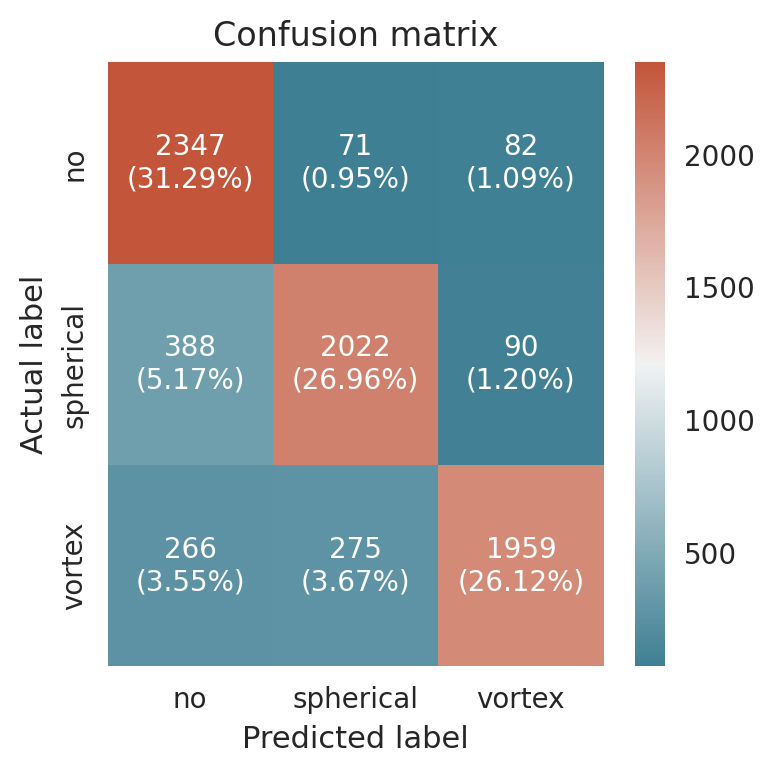

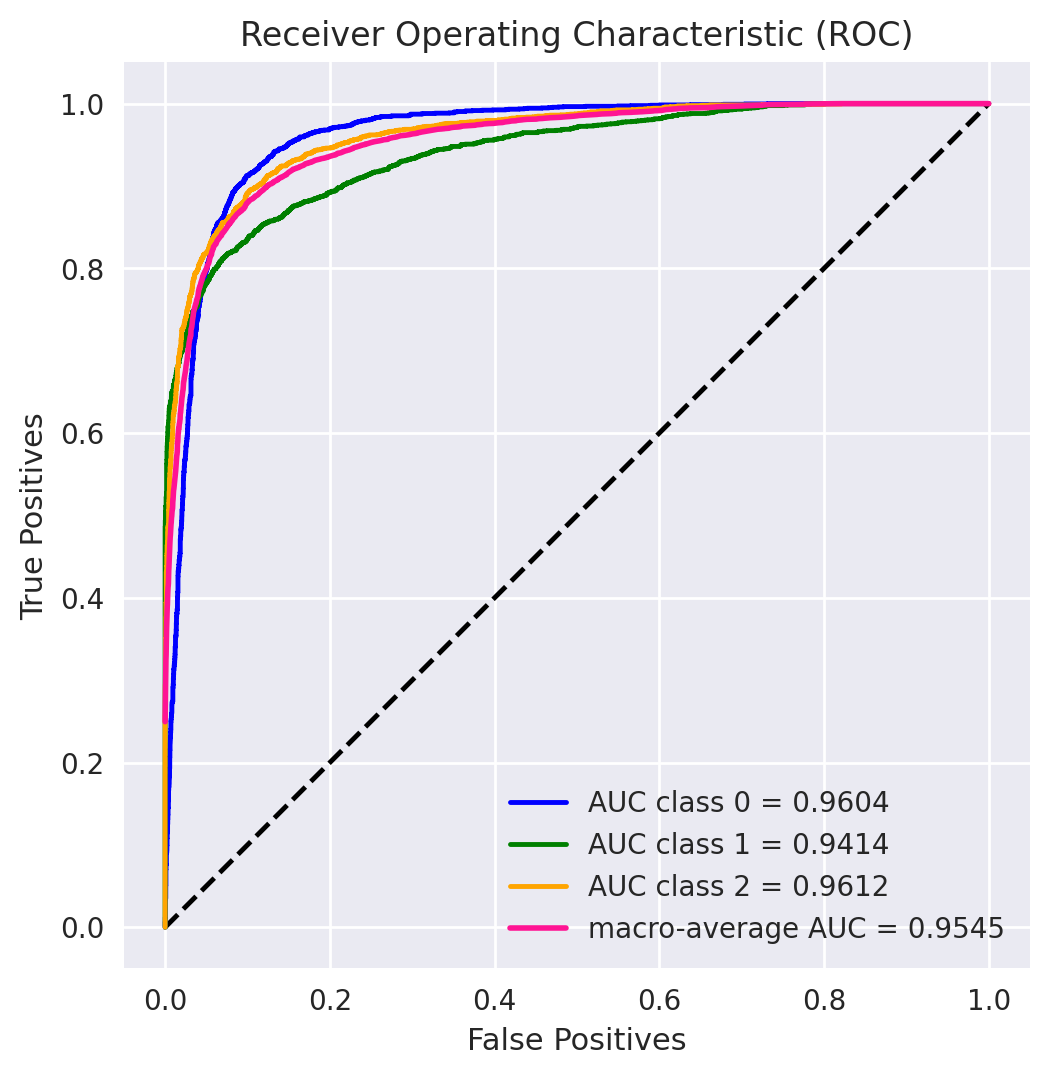

In [25]:
# returns accuracy on the test set
print(f"accuracy on test set = {adda.evaluate(target_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
adda.plot_cm_roc(target_dataloader_test)